In [1]:
import pandas as pd
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
results = pd.read_csv("./results.csv")
print(results.columns.values)

['MB' 'agility' 'conflicts' 'constraints' 'learned' 'level' 'limit'
 'original' 'satisfiable' 'seconds' 'sudoku' 'used' 'variables']


In [19]:
results.shape

(76963, 13)

In [3]:
constraints = ["all",
        # 3 combos
        "x_y_block",
        "x_z_block",
        "y_z_block",
        "x_y_z",
        # 2 Combos
        "x_y",
        "x_z",
        "y_z",
        "x_block",
        "y_block",
        "z_block",
        # Singles
        "x",
        "y",
        "z",
        "block"
        ]

def calculate_mean_uncertainty(mean, max_val, min_val, values):
    squared_sum = ((values - mean)**2).sum()
    sigma = math.sqrt(squared_sum / values.size)
    mean_uncertainty = sigma / math.sqrt(values.size)
    return mean_uncertainty
    
average_dict = []
for constraint in constraints:
    constraint_results = results[results["constraints"].isin([constraint])]
    level_results = constraint_results["level"]
    print(constraint, str(5354-level_results.size))
    constraint_max = level_results.max()
    constraint_min = level_results.min()
    constraint_avg = level_results.mean()
    constraint_avg_uncertainty = calculate_mean_uncertainty(constraint_avg,
                                                            constraint_max,
                                                            constraint_min,
                                                            level_results)
    average_dict.append({
        "constraint": constraint,
        "average": constraint_avg,
        "average_uncertainty": constraint_avg_uncertainty
    })

average_df = pd.DataFrame(average_dict)
average_df = average_df.set_index(average_df.constraint)
del average_df["constraint"]
print(average_df[average_df.index == "all"])

all 367
x_y_block 0
x_z_block 0
y_z_block 0
x_y_z 2980
x_y 0
x_z 0
y_z 0
x_block 0
y_block 0
z_block 0
x 0
y 0
z 0
block 0
             average  average_uncertainty
constraint                               
all         6.507894             0.119253


In [4]:
def divide_with_uncertainty(numerator, num_uncertainty, denominator, denom_uncertainty):
    quotient = numerator / denominator
    abs_quotient = abs(quotient)
    square_root_un = math.sqrt((num_uncertainty/numerator)**2 + (denom_uncertainty/denominator)**2)
    quotient_uncertainty = abs_quotient * square_root_un
    return quotient, quotient_uncertainty
    

In [5]:
def generate_key_mapping(df):
    constraints = ["all",
        # 3 combos
        "x_y_block",
        "x_z_block",
        "y_z_block",
        "x_y_z",
        # 2 Combos
        "x_y",
        "x_z",
        "y_z",
        "x_block",
        "y_block",
        "z_block",
        # Singles
        "x",
        "y",
        "z",
        "block"
        ]
    mapping = {constraint: i for i, constraint in enumerate(constraints)}
    key = df["constraints"].map(mapping)
    return key.argsort()

In [6]:
constraints_avg = results.groupby(["constraints"]).mean().add_suffix("_mean").reset_index()
constraints_avg = constraints_avg.iloc[generate_key_mapping(constraints_avg)]

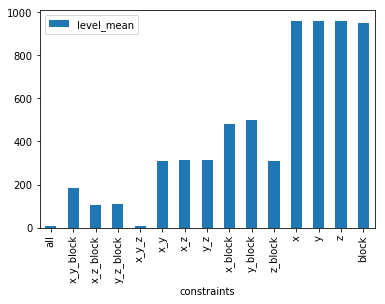

In [7]:
constraints_avg.plot(x="constraints", y="level_mean", kind="bar")

In [18]:
print(constraints_avg[["constraints", "level_mean"]].to_latex(index=False))

\begin{tabular}{lr}
\toprule
constraints &  level\_mean \\
\midrule
        all &    6.507894 \\
  x\_y\_block &  181.843220 \\
  x\_z\_block &  105.605603 \\
  y\_z\_block &  111.127232 \\
      x\_y\_z &    8.734983 \\
        x\_y &  307.721815 \\
        x\_z &  313.153474 \\
        y\_z &  313.309301 \\
    x\_block &  479.311524 \\
    y\_block &  500.234516 \\
    z\_block &  308.272768 \\
          x &  960.703399 \\
          y &  960.182013 \\
          z &  960.736272 \\
      block &  948.700504 \\
\bottomrule
\end{tabular}



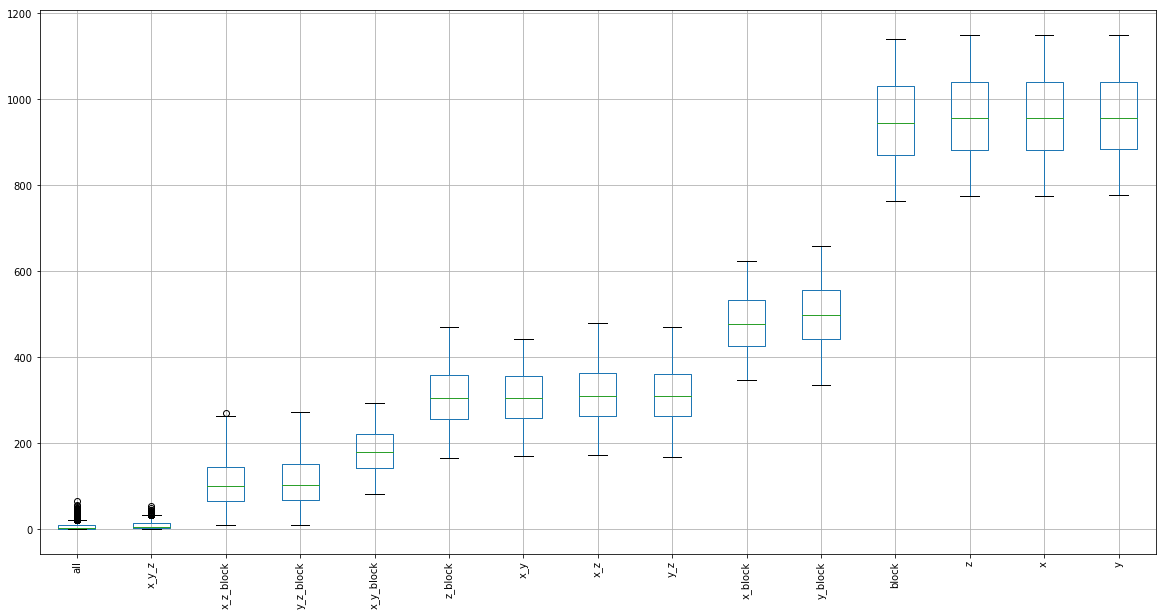

In [11]:
sorted_results = results.iloc[generate_key_mapping(results)]
constraints = ["all",
        # 3 combos
        "x_y_block",
        "x_z_block",
        "y_z_block",
        "x_y_z",
        # 2 Combos
        "x_y",
        "x_z",
        "y_z",
        "x_block",
        "y_block",
        "z_block",
        # Singles
        "x",
        "y",
        "z",
        "block"
        ]
constraints_tup = [(constraint, "level") for constraint in constraints]


def boxplot_sorted(df, by, column, figsize=(20, 10), save_fig = None):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=90, figsize=figsize)
    
    if save_fig:
        plt.savefig(save_fig, dpi=600)
  

boxplot_sorted(sorted_results, by="constraints", column="level", save_fig="../images/level_box_plot.png")
# whisker = sorted_results.boxplot(column="level", by="constraints", layout=(["all"], "level"))

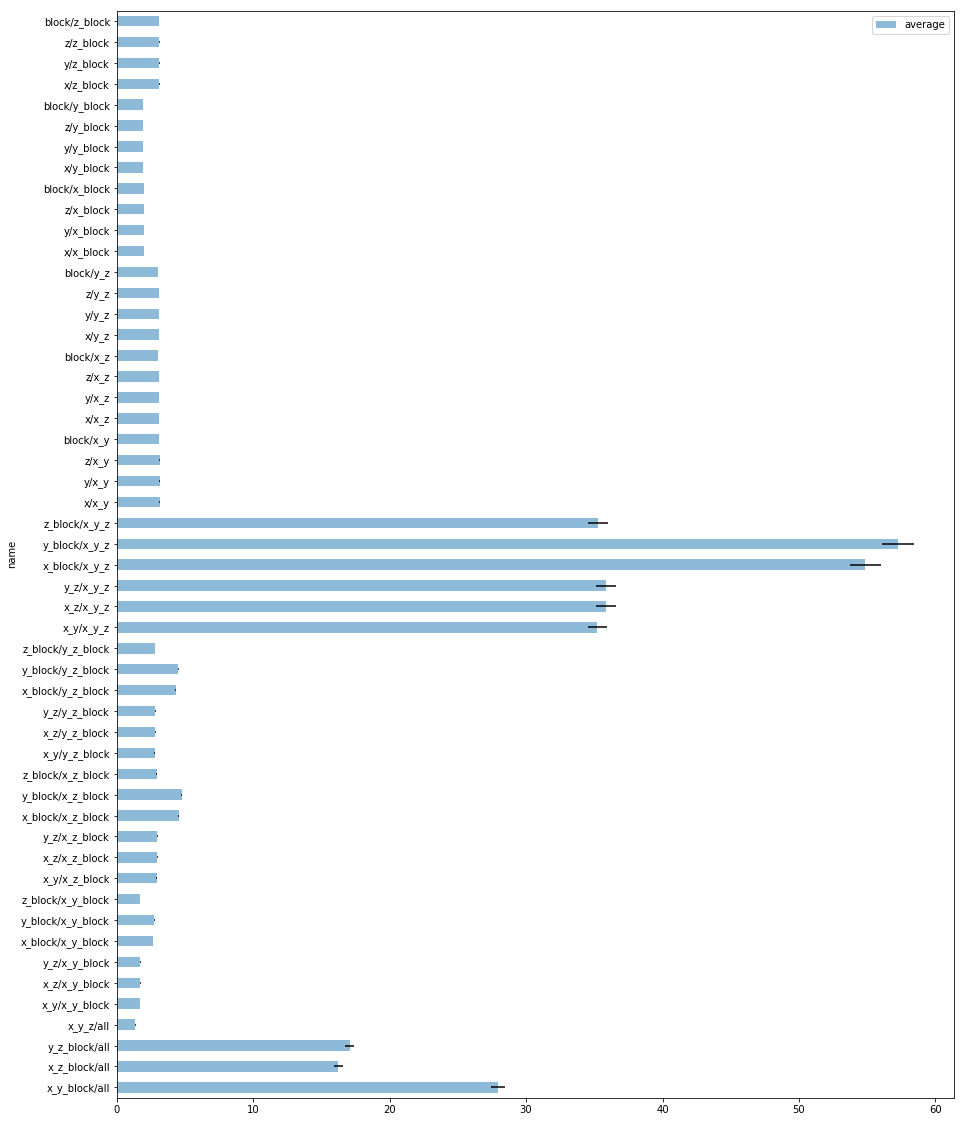

In [77]:
import itertools
combos = {
    "comb4": ["all"],
    "comb3": [   
        "x_y_block",
        "x_z_block",
        "y_z_block",
        "x_y_z"
    ],
    "comb2": [
        "x_y",
        "x_z",
        "y_z",
        "x_block",
        "y_block",
        "z_block"
    ],
    "comb1": [
        "x",
        "y",
        "z",
        "block"
    ]
}

relative_sizes = [
    ("comb4", "comb3"),
    ("comb3", "comb2"),
    ("comb2", "comb1")
]


relative_dict = []
for more_restrictive, less_restrictive in relative_sizes:
    more_restrictive_constraints = combos[more_restrictive]
    less_restrictive_constraints = combos[less_restrictive]
    combinations = list(
        itertools.product(more_restrictive_constraints, less_restrictive_constraints)
    )
    
    for larger_constraints, smaller_constraints in combinations:
        quotient, quotient_uncert = divide_with_uncertainty(
            average_df.get_value(smaller_constraints,"average"),
            average_df.get_value(smaller_constraints,"average_uncertainty"),
            average_df.get_value(larger_constraints,"average"),
            average_df.get_value(larger_constraints,"average_uncertainty")
        )
        
        relative_name = "{}/{}".format(smaller_constraints, larger_constraints)
        relative_dict.append({
            "name": relative_name,
            "average": quotient,
            "average_err": quotient_uncert
        })

relative_df = pd.DataFrame(relative_dict)
relative_df = relative_df.set_index(relative_df.name)
relative_df.plot.barh(xerr="average_err", figsize=(15, 20), alpha=0.5)
plt.savefig("./error_bars.png", dpi=600)